<a href="https://colab.research.google.com/github/PrateekKumar135/GEN_AI_-GAN-/blob/main/Copy_of_GAN_MODEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization, LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
import tensorflow_datasets as tfds

# Preprocessing function

In [ ]:
# Resize the images to a fixed size (e.g., 128x128)
def preprocess_image(image):
    # Resize the image  and normalize it to the range [-1, 1]
    image = tf.image.resize(image, (64, 64))  # Resize
    image = (image.numpy().astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
    return image

# Build Generator Model

In [ ]:
def build_generator():
    model = Sequential()
    model.add(Dense(256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(64 * 64 * 3, activation='tanh')) # Output shape: 64x64x3 for RGB
    model.add(Reshape((64,64,3)))   # Reshaping to RGB image
    return model



# Build Discriminator Model

In [ ]:
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(64, 64, 3)))  # Input shape for RGB images
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))  # Output for binary classification i.e real or fake
    return model


# Load and preprocess dataset

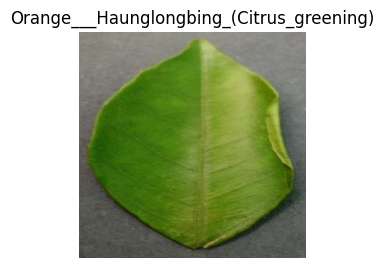

In [ ]:
# Construct a tf.data.Dataset
ds,ds_info = tfds.load('plant_village', split='train', shuffle_files=True, with_info=True)
# Get class names from the dataset info
class_names = ds_info.features["label"].names

# Plot a grid of images
plt.figure(figsize=(10, 10))
for example in ds.take(100):  # Take one batch
    images = example["image"]
    labels = example["label"]
    ax = plt.subplot(3, 3, 8)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[labels.numpy()])
    plt.axis("off")

In [ ]:
images = []

# Collect images from the dataset and ensure they are in RGB format
images = []
for example in ds:
    image = example["image"].numpy()  # Convert the image to a numpy array
    image = preprocess_image(image)  # Preprocess the image (resize and normalize)
    images.append(image)

X_train = np.array(images)


# Build models

In [ ]:
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Create GAN Model

In [ ]:
discriminator.trainable = False

gan_input = Input(shape=(100,))
generated_image = generator(gan_input)
gan_output = discriminator(generated_image)

gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')


# Training function

In [ ]:
def train_gan(epochs, batch_size=128):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        generated_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real)

        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")
            save_images(epoch)


 # Save generated images
def save_images(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    fig, axs = plt.subplots(r, c)
    count = 0
    for i in range(r):
        for j in range(c):
            # axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')
            axs[i, j].imshow(generated_images[count])  # Display in RGB format
            axs[i, j].axis('off')
            count += 1
    fig.savefig(f"gan_images_{epoch}.png")
    plt.close()

# Train the GAN
train_gan(epochs=1000, batch_size=64)

2/2 [==============================] - 0s 14ms/step
0 [D loss: 0.8712636232376099, acc.: 48.4375] [G loss: 0.845844566822052]
2/2 [==============================] - 0s 8ms/step
100 [D loss: 0.29660287499427795, acc.: 89.84375] [G loss: 2.5157554149627686]
2/2 [==============================] - 0s 8ms/step
200 [D loss: 0.3402221202850342, acc.: 86.71875] [G loss: 2.125370979309082]
2/2 [==============================] - 0s 8ms/step
300 [D loss: 0.3995685577392578, acc.: 86.71875] [G loss: 1.9675631523132324]
2/2 [==============================] - 0s 25ms/step
400 [D loss: 0.41565802693367004, acc.: 80.46875] [G loss: 2.519998550415039]
2/2 [==============================] - 0s 9ms/step
500 [D loss: 0.4322383850812912, acc.: 82.8125] [G loss: 2.453324794769287]
2/2 [==============================] - 0s 20ms/step
600 [D loss: 0.39540891349315643, acc.: 79.6875] [G loss: 3.153045415878296]
2/2 [==============================] - 0s 7ms/step
700 [D loss: 0.5312248170375824, acc.: 72.65625] [